In [14]:
import glob
import json
import os
import requests
import sys

from dotenv import load_dotenv
from io import BytesIO
from PIL import Image
from urllib.parse import urlparse
from pprintjson import pprintjson
import logging

In [57]:
sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

In [15]:
load_dotenv("azure.env")
key = os.getenv("azure_cv_key")
endpoint = os.getenv("azure_cv_endpoint")

In [16]:
url = endpoint + "/computervision/imageanalysis:segment?api-version=2023-02-01-preview"
background_removal = "&mode=backgroundRemoval"
foreground_matting = "&mode=foregroundMatting"

remove_background_url = url + background_removal  # For removing the background
get_mask_object_url = url + foreground_matting  # Mask of the object

headers = {"Content-type": "application/json", 
           "Ocp-Apim-Subscription-Key": key}

In [17]:
IMAGES_DIR = "images"
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [18]:
def remove_background(image_url):
    """
    Removing background
    """
    image = {"url": image_url}
    r = requests.post(remove_background_url, data=json.dumps(image), headers=headers)

    object_image = os.path.join(
        RESULTS_DIR, "object_" + os.path.basename(urlparse(image_url).path)
    )

    with open(object_image, "wb") as f:
        f.write(r.content)

    return Image.open(object_image)

def get_mask(image_url):
    """
    Get Mask
    """
    image = {"url": image_url}
    r = requests.post(get_mask_object_url, data=json.dumps(image), headers=headers)

    mask_image = os.path.join(
        RESULTS_DIR, "mask_" + os.path.basename(urlparse(image_url).path)
    )

    with open(mask_image, "wb") as f:
        f.write(r.content)

    return Image.open(mask_image)


def get_stats(image):
    """
    Pixel stats on mask image
    """
    image = image.convert("L")
    width, height = image.size
    total_pixels = width * height
    black_pixels = 0

    for x in range(width):
        for y in range(height):
            if image.getpixel((x, y)) == 0:
                black_pixels += 1

    white_pixels = total_pixels - black_pixels
    pct_whitepixels = white_pixels / total_pixels
    pct_blackpixels = black_pixels / total_pixels

    print("Number of pixels:", "{:,}".format(total_pixels))
    
    print(
        "\nNumber of black pixels:",
        "{:,}".format(black_pixels),
        f"{pct_blackpixels:.2%}",
    )

    print(
        "Number of white pixels:", "{:,}".format(white_pixels), f"{pct_whitepixels:.2%}"
    )

In [9]:
# Code to upload to bucket
from typing import Dict, Any, Optional, BinaryIO
from google.cloud import storage
load_dotenv("azure.env")
BUCKET_NAME = os.getenv('BUCKET_NAME')
project_id = os.getenv('PROJECT_ID')
SERVICE_ACCOUNT_JSON = os.getenv('GOOGLE_APPLICATION_CREDENTIALS') 
UPLOAD_FOLDER = "raw_images"
PROCESSED_FOLDER = "processed_images"

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def upload_blob(source_file_name: str, destination_blob_name: str, bucket_name: str = BUCKET_NAME) -> Optional[str]:
    """Uploads a file to Google Cloud Storage and returns its public URL."""
    try:
        storage_client = storage.Client(project=project_id)
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(destination_blob_name)

        blob.upload_from_filename(source_file_name, if_generation_match=0)
        logger.info(f"File {source_file_name} uploaded to {destination_blob_name}.")
        
        blob.make_public()
        return blob.public_url
    except Exception as e:
        logger.error(f"Error uploading file to GCS: {e}")
        return None

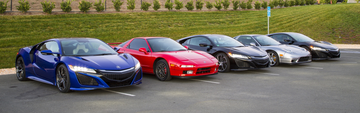

In [61]:
image_url = "https://github.com/retkowsky/Azure-Computer-Vision-in-a-day-workshop/blob/main/images/cars.jpg?raw=true"

r = requests.get(image_url)
img = Image.open(BytesIO(r.content))
img.thumbnail((360, 360), Image.Resampling.LANCZOS)
img

In [10]:
# Destination name in the bucket
source_file_name = f'images/d95cddc1418d25199efda1cf40726f43.jpg'  # Adjust the path as needed
destination_blob_name = f'{UPLOAD_FOLDER}/blonde.png'  # Adjust the path as needed

# Call the function to upload the file
public_url_raw = upload_blob(source_file_name, destination_blob_name, BUCKET_NAME)
public_url_raw

INFO:__main__:File images/d95cddc1418d25199efda1cf40726f43.jpg uploaded to raw_images/blonde.png.


'https://storage.googleapis.com/image-data-asg-2/raw_images/blonde.png'

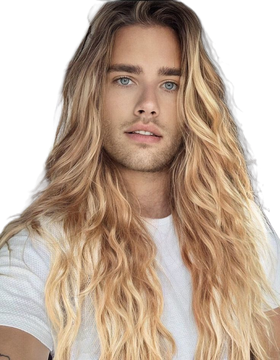

In [19]:
remove_background_img = remove_background(public_url_raw)
remove_background_img.thumbnail((360, 360), Image.Resampling.LANCZOS)
remove_background_img


In [20]:
# Save the processed image in the 'images' folder
image_path = os.path.join('images', 'processed_image.png')
remove_background_img.save(image_path)

In [21]:
# Destination name in the bucket
source_file_name = f'images/processed_image.png'  # Adjust the path as needed
destination_blob_name = f'{PROCESSED_FOLDER}/blonde.png'  # Adjust the path as needed

# Call the function to upload the file
public_url_raw = upload_blob(source_file_name, destination_blob_name, BUCKET_NAME)
public_url_raw

INFO:__main__:File images/processed_image.png uploaded to processed_images/blonde.png.


'https://storage.googleapis.com/image-data-asg-2/processed_images/blonde.png'

In [22]:
url_caption = (
    endpoint
    + "/computervision/imageanalysis:analyze?api-version=2023-02-01-preview&features=denseCaptions&language=en"
)

headers_caption = {"Content-type": "application/json", "Ocp-Apim-Subscription-Key": key}

In [24]:
r = requests.post(url_caption, data=json.dumps({"url": public_url_raw}), headers=headers_caption)
results = r.json()
print(results)
[value['text'] for value in results['denseCaptionsResult']['values']]

{'denseCaptionsResult': {'values': [{'text': 'a man with long blonde hair', 'confidence': 0.8823651671409607, 'boundingBox': {'x': 0, 'y': 0, 'w': 280, 'h': 360}}, {'text': 'a man with long blonde hair', 'confidence': 0.8868788480758667, 'boundingBox': {'x': 0, 'y': 0, 'w': 274, 'h': 351}}, {'text': "a close up of a person's hair", 'confidence': 0.7714547514915466, 'boundingBox': {'x': 0, 'y': 185, 'w': 275, 'h': 166}}, {'text': 'a close up of a white fabric', 'confidence': 0.7521333694458008, 'boundingBox': {'x': 0, 'y': 231, 'w': 56, 'h': 125}}, {'text': 'a close up of a blonde hair', 'confidence': 0.6968230605125427, 'boundingBox': {'x': 108, 'y': 210, 'w': 96, 'h': 146}}]}, 'modelVersion': '2023-02-01-preview', 'metadata': {'width': 280, 'height': 360}}


['a man with long blonde hair',
 'a man with long blonde hair',
 "a close up of a person's hair",
 'a close up of a white fabric',
 'a close up of a blonde hair']

In [27]:
from gradio_client import Client, handle_file

client = Client("gokaygokay/Florence-2-SD3-Captioner")
result = client.predict(
		image=handle_file("https://storage.googleapis.com/image-data-asg-2/processed_images/blonde.png"),
		task_prompt="Caption",
		text_input=None,
		model_id="microsoft/Florence-2-large",
		api_name="/process_image"
)
print(result)

INFO:httpx:HTTP Request: GET https://gokaygokay-florence-2-sd3-captioner.hf.space/config "HTTP/1.1 200 OK"


Loaded as API: https://gokaygokay-florence-2-sd3-captioner.hf.space ✔


INFO:httpx:HTTP Request: GET https://gokaygokay-florence-2-sd3-captioner.hf.space/info?serialize=False "HTTP/1.1 200 OK"


ValueError: Cannot find a function with `api_name`: /process_image.

INFO:httpx:HTTP Request: GET https://gokaygokay-florence-2-sd3-captioner.hf.space/heartbeat/98889901-10db-409c-8fb4-70454aab507c "HTTP/1.1 200 OK"


In [29]:

# gokaygokay/Florence-2-SD3-Captioner
from gradio_client import Client, handle_file
client = Client("gokaygokay/Florence-2-SD3-Captioner")
result = client.predict(
		image=handle_file('https://storage.googleapis.com/image-data-asg-2/processed_images/blonde.png'),
		api_name="/run_example"
)

print(result)
 

Loaded as API: https://gokaygokay-florence-2-sd3-captioner.hf.space ✔


INFO:httpx:HTTP Request: GET https://gokaygokay-florence-2-sd3-captioner.hf.space/config "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://gokaygokay-florence-2-sd3-captioner.hf.space/info?serialize=False "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://gokaygokay-florence-2-sd3-captioner.hf.space/heartbeat/1dbb8096-0554-4eed-9446-8f60df79b999 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gokaygokay-florence-2-sd3-captioner.hf.space/queue/join "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://gokaygokay-florence-2-sd3-captioner.hf.space/queue/data?session_hash=1dbb8096-0554-4eed-9446-8f60df79b999 "HTTP/1.1 200 OK"


A close-up portrait of a man with long blonde hair and blue eyes. He is wearing a white t-shirt with a white collar. His hair is cascading over his shoulders. His eyes are a piercing blue and he has a slight smile on his lips. His eyebrows are a light brown color and his eyelashes are a darker brown color. He has a white mustache and beard. His left hand is visible in the bottom left corner of the frame. The background is completely black.


# Analyze Image

In [7]:
import os
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential

# Set the values of your computer vision endpoint and computer vision key
# as environment variables:
try:
    endpoint = os.environ["azure_cv_endpoint"]
    key = os.environ["azure_cv_key"]
except KeyError:
    print("Missing environment variable 'VISION_ENDPOINT' or 'VISION_KEY'")
    print("Set them before running this sample.")
    exit()

# Create an Image Analysis client
client = ImageAnalysisClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(key)
)

# Get a caption for the image. This will be a synchronously (blocking) call.
result = client.analyze_from_url(
    image_url='https://storage.googleapis.com/image-data-asg-2/processed_images/yoga_pants_processed.png',
    visual_features=[VisualFeatures.CAPTION, VisualFeatures.READ],
    gender_neutral_caption=True,  # Optional (default is False)
)

print("Image analysis results:")
# Print caption results to the console
print(" Caption:")
if result.caption is not None:
    print(f"   '{result.caption.text}', Confidence {result.caption.confidence:.4f}")

# Print text (OCR) analysis results to the console
print(" Read:")
if result.read is not None:
    # for line in result.read.blocks[0].lines:
    #     print(f"   Line: '{line.text}', Bounding box {line.bounding_polygon}")
    #     for word in line.words:
    #         print(f"     Word: '{word.text}', Bounding polygon {word.bounding_polygon}, Confidence {word.confidence:.4f}")
    print(result.read)

Image analysis results:
 Caption:
   'a person in a purple outfit', Confidence 0.6986
 Read:
{'blocks': []}
